### 一.简介
这一章开始EM算法的探索，EM即Expectation Maximization，称为期望极大算法；如果直接介绍EM算法会有些云里雾里，所以这一节会先介绍GMM（Gaussian mixture model,高斯混合模型），然后由此引出EM算法的求解，我们首先看看单个的高斯模型求解

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 二.单个高斯分布

假如，我们有如下的一堆一维数据点，并且知道它iid采样于某一一维高斯分布

(-0.1, 1)

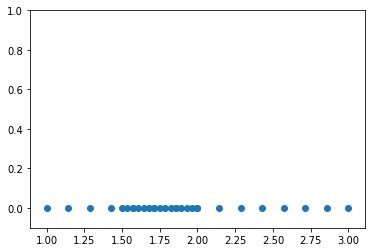

In [2]:
data=np.sort(np.linspace(1,3,15).tolist()+np.linspace(1.5,2,15).tolist())
plt.scatter(data,[0]*len(data))
plt.ylim(-0.1,1)

我们知道一维高斯分布的概率密度函数如下：   

$$
N(x\mid u,\sigma)=\frac{1}{\sqrt{2\pi}\cdot\sigma}exp(-\frac{(x-u)^2}{2\sigma^2})
$$

那么该如何求该高斯分布参数呢？即估计高斯参数$u,\sigma$，极大似然估计便是一种常用的方法
#### 极大似然估计

极大似然估计是一种点估计，它目标函数即似然函数，如下：   

$$
L(u,\sigma)=\prod_{i=1}^MN(x_i\mid u,\sigma)
$$

$M$表示样本量，我们要求解：  

$$
u^*,\sigma^*=arg\max_{u,\sigma}L(u,\sigma)
$$  

可以简单的理解为让样本出现的概率尽可能的大，由于累乘不好计算，通常会对似然函数取对数，将乘号变为加号，这时的目标函数表示如下：   

$$
L(u,\sigma)=log(\prod_{i=1}^Mp(x_i\mid u,\sigma))=-Mlog(\sqrt{2\pi}\cdot\sigma)-\sum_{i=1}^M\frac{(x-u)^2}{2\sigma^2}
$$  

显然取对数后的最优解和取对数前一致，由于极值点必然是导数为0的点，所以，我们分别让$L(u,\sigma)$对$u,\sigma$求偏导，并令其为0，即可得到$u^*,\sigma^*$：  

$$
\frac{\partial L(u,\sigma)}{\partial u}=\frac{1}{\sigma^2}\sum_{i=1}^M(x_i-u)=0\Rightarrow u^*=\frac{\sum_{i=1}^Mx_i}{M}
$$

$$
\frac{\partial L(u,\sigma)}{\partial \sigma}=-M\frac{1}{\sigma}+\sum_{i=1}^M(x-u)^2\sigma^{-3}=0\Rightarrow\sigma^*=\sqrt{\frac{\sum_{i=1}^M(x-u^*)^2}{M}}
$$

结果非常简单且好理解，对于上面的伪数据，我们可以很方便的求解出其高斯分布的参数

In [3]:
#定义一维高斯概率分布函数
def gaussian_1d(x,u,sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-1*np.power(x-u,2)/(2*sigma**2))
u=np.mean(data)
sigma=np.std(data)

(-0.1, 1)

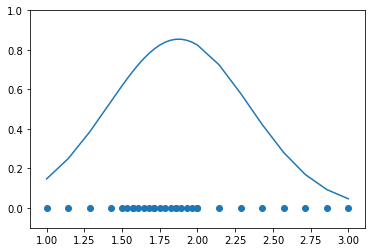

In [4]:
plt.scatter(data,[0]*len(data))
plt.plot(data,gaussian_1d(data,u,sigma))
plt.ylim(-0.1,1)

### 二.多个高斯分布
可以发现结果比较make sense，数据密集的地方，对应的概率密度也很高，接着我们再造一些数据看看，比如下面，这部分数据明显可以分为两部分，中间有隔断，如果再用一个高斯分布去拟合，其结果就有些牵强了,概率分布高的地方零星只有几个点的数据

(-0.1, 1)

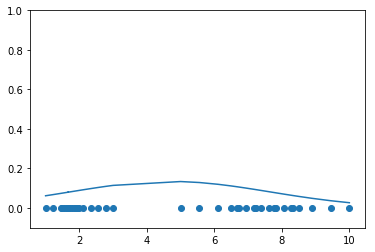

In [5]:
data1=sorted(np.linspace(1,3,10).tolist()+np.linspace(1.5,2,10).tolist())
data2=sorted(np.linspace(5,10,10).tolist()+np.linspace(6.5,8.5,10).tolist())
u=np.mean(data1+data2)
sigma=np.std(data1+data2)
plt.scatter(data1+data2,[0]*len(data1+data2))
plt.plot(data1+data2,gaussian_1d(data1+data2,u,sigma))
plt.ylim(-0.1,1)

既然一个高斯分布不能很好的拟合这些数据，那就多个去拟合？这便是**高斯混合模型**，我们分别构建两个高斯分布去拟合左右两侧的数据看看效果

(-0.1, 1)

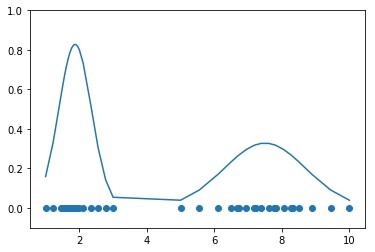

In [7]:
data1=sorted(np.linspace(1,3,10).tolist()+np.linspace(1.5,2,10).tolist())
data2=sorted(np.linspace(5,10,10).tolist()+np.linspace(6.5,8.5,10).tolist())
u1=np.mean(data1)
u2=np.mean(data2)
sigma1=np.std(data1)
sigma2=np.std(data2)
plt.scatter(data1+data2,[0]*len(data1+data2))
plt.plot(data1+data2,gaussian_1d(data1+data2,u1,sigma1)+gaussian_1d(data1+data2,u2,sigma2))
plt.ylim(-0.1,1)

nice,该凸的地方凸了,该凹的地方凹了，但这里还有一个问题，如果对该概率分布做积分，其结果为2，因为包含了两个高斯分布，每个高斯分布的积分都为1，所以我们还需要对每个高斯分布的权重进行约束，假设$\alpha_1$为第一个高斯分布的权重，$\alpha_2$为第二个高斯分布的权重，那么，需要满足如下约束：  

$$
\alpha_1+\alpha_2=1,\alpha_1\geq 0,\alpha_2\geq 0
$$  

我们不妨假设$\alpha_1=0.5,\alpha_2=0.5$，所以一个比较合理的分布如下：  

(-0.1, 1)

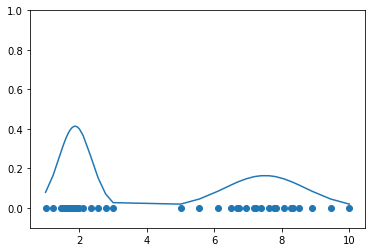

In [8]:
alpha1=0.5
alpha2=0.5
plt.scatter(data1+data2,[0]*len(data1+data2))
plt.plot(data1+data2,alpha1*gaussian_1d(data1+data2,u1,sigma1)+alpha2*gaussian_1d(data1+data2,u2,sigma2))
plt.ylim(-0.1,1)

到这里，我们通过两个高斯分布去模拟数据的概率分布，并取得了看起来不错的效果，但整个过程都是靠“人”的先验知识去完成的，比如（1）通过观测数据的分布，人为的选择了两个高斯分布；（2）一个高斯分布只去学习左侧数据，另一个高斯分布只去学习右侧的数据；（3）人为的为每个高斯分布的权重设置为0.5，但我们更加希望这个过程是能自动完成的，即自动去学习参数$\theta=\{u_1,\sigma_1,u_2,\sigma_2,\alpha_1\}$，所以让我们从头开始，假设，现在的高斯混合模型为：   

$$
P(x\mid\theta)=\alpha_1N_1(x\mid u_1,\sigma_1)+(1-\alpha_1)N_2(x\mid u_2,\sigma_2)=\sum_{i=1}^2\alpha_iN_i(x\mid u_i,\sigma_i),\alpha_2=1-\alpha_1
$$  

对这些参数的求解，我们同样可以使用最大对数似然估计的方式，所以，损失函数：   

$$
L(\theta)=log(\prod_{i=1}^MP(x_i\mid \theta))=\sum_{i=1}^MlogP(x_i\mid \theta)=\sum_{i=1}^Mlog[\sum_{k=1}^2\alpha_kN_k(x_i\mid u_k,\sigma_k)]
$$  

接下来，按之前的思路，我们分别对各个参数求偏导并令其为0，不是就可以解出最优参数了？可问题是现在很难解...,不信，那下面推导一下损失函数$L(\theta)$对$u_k$的偏导（$k=1,2$）：   

$$
\frac{\partial L(\theta)}{\partial u_k}=\sum_{i=1}^M\frac{\frac{\alpha_k(x_i-u_k)}{\sqrt{2\pi}\sigma_k^3}exp(-\frac{(x_i-u_k)^2}{2\sigma_k^2})}{\sum_{j=1}^2\alpha_jN_j(x_i\mid u_j,\sigma_j)}=0 \Rightarrow 谁能直接算出来，请联系我
$$  

所以，需要转换一种思路去求解，EM是一种迭代逐步优化的思路，它主要分为两步，第一步求期望(E)，第二步对其求极大化(M)，重复执行这两步，直到收敛，即找到一组$\theta^1->\theta^2->,...,->\theta^i$使得$L(\theta^1)<L(\theta^2)<\cdots<L(\theta^i)$，接下来，在下一节介绍EM算法流程